# Проверка моделей 

### KFold

In [14]:
import pandas
import pickle
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [1]:
def get_prediction(model, X_test, Y_test):
    prediction = model.predict(X_test)
    lst1 = list(map(lambda i:round(i,2), list(prediction)))
    lst1 = [i - 0.5 for i in lst1]
    lst1 = [1 if i < 1 else i for i in lst1]
    lst1 = list(map(lambda i:round(i,2), lst1))
    lst1clip = np.clip(lst1, 0., 2.)
    lst2 = list(Y_test.future_0)
    return [lst1clip, lst2]

In [4]:
def my_mae(pred,real):
    lst= [1 for i in range(len(pred)) if pred[i] > real[i]]
    return sum(lst) / len(pred)

In [5]:
X_train = pandas.read_csv("trainDS_X.csv")
Y_train = pandas.read_csv("trainDS_Y.csv")
X_train = X_train.drop(X_train.columns[[0]], axis='columns')
Y_train = Y_train.drop(Y_train.columns[[0]], axis='columns')

In [6]:
def check_bank(model, X_test, Y_test, plot = False):
    mes = "Вы не проиграли банк"
    lst1clip=get_prediction(model, X_test, Y_test)[0]
    lst2=get_prediction(model, X_test, Y_test)[1]
    bank = 20
    bank_list=[]
    pred = 0
    for i in range(1, len(lst1clip)):
        if bank < 0:
            mes = f"Вы проиграли весь банк, сыграв {i} игр"
            break
        if lst1clip[i] >= 1.65 or lst1clip[i - 1] - lst1clip[i] < -0.04:
            if lst2[i] >= 2:
                bank += 1
            else:
                bank -= 1
        bank = round(bank,2)
        bank_list.append(bank)
        
    if plot:
        plt.plot(bank_list, label="bank")
        plt.xlabel("Кол-во игр")
        plt.ylabel("Выигрыш")
        plt.legend()
    print(f"минимум = {min(bank_list)}")
    print(f"максимум = {max(bank_list)}")
    print(f"итого за 1000 игр = {bank_list[-1]}")
    return([mes,bank_list[-1]])

In [7]:
def heldout_score(clf, X_test, Y_test):
    """вычисление ошибки"""
    prediction = clf.predict(X_test)
    lst1clip = [i-0.5 for i in prediction]
    lst1clip = np.clip(lst1clip, 1., 2.)
    real = list(Y_test.future_0)
    rmse = mean_squared_error(real, lst1clip)
    return round(np.sqrt(rmse),2)

In [8]:
def kFold(n_splits):
    objlist = []
    a = np.arange(len(X_train))
    parts = np.array_split(a, n_splits)
    sa = set(a)
    for part in parts:
        sp = set(part)
        cur = [list(sa.difference(sp)), list(sp)]
        objlist.append(cur)
    return objlist

In [12]:
def LGBM_estimate(n_splits):
    empty_bank = 0
    total_bank = 0
    error = 0
    cv_clf = LGBMRegressor(max_depth = 50, learning_rate = 0.1, n_estimators = 100)
    objlist = kFold(n_splits)
    i=1
    
    for train, test in objlist:
        cv_clf.fit(X_train.loc[train], Y_train.loc[train])
        filename = f'model_LGBMR{i}.sav'
        pickle.dump(cv_clf, open(filename, 'wb'))
        error += heldout_score(cv_clf, X_train.loc[test], Y_train.loc[test])
        error = round(error,2)
        i+=1
        if check_bank(cv_clf,X_train.loc[test],Y_train.loc[test])[0]!="Вы не проиграли банк":
            empty_bank+=1
            total_bank-=20
        else:
            total_bank+=check_bank(cv_clf,X_train.loc[test],Y_train.loc[test])[1]
        
    error /= n_splits
    return [error,empty_bank,total_bank]

In [10]:
def xgb_estimate(n_splits):
    empty_bank = 0
    total_bank = 0
    error = 0
    cv_clf = xgb.XGBRegressor(booster='gbtree', verbosity=0, learning_rate=0.1, n_estimators=200, max_depth=50 )
    objlist = kFold(n_splits)
    
    for train, test in objlist:
        cv_clf.fit(X_train.loc[train], Y_train.loc[train])
        filename = f'model_xgb{i}.sav'
        pickle.dump(cv_clf, open(filename, 'wb'))
        error += heldout_score(cv_clf, X_train.loc[test], Y_train.loc[test])
        error = round(error,2)
        if check_bank(cv_clf,X_train.loc[test],Y_train.loc[test])[0]!="Вы не проиграли банк":
            empty_bank+=1
            total_bank-=20
        else:
            total_bank+=check_bank(cv_clf,X_train.loc[test],Y_train.loc[test])[1]
        
    error /= n_splits
    total_bank /= n_splits
    return [error,empty_bank,total_bank]

In [21]:
def prediction(model, tests):
    X_test = tests[0]
    Y_test = tests[1]
    prediction = model.predict(X_test)
    lst1clip = prediction
    lst1clip = [i for i in lst1clip]
    lst1clip = np.clip(lst1clip, 1., 2.)
    lst2 = list(Y_test.future_0)
    return[lst1clip,lst2]

### Тестирование LGBMRegressor

In [ ]:
res = LGBM_estimate(40)

In [59]:
print("Средняя ошибка:", res[0])
print(f"Банк опустел в {res[1]} случаев")
print("Средний выигрыш:", res[2])

Средняя ошибка: 4.10325
Банк опустел в 0 случаев
Средний выигрыш: 49


In [19]:
models = [pickle.load(open(f'model_LGBMR{i}.sav', 'rb')) for i in range(1,41)]
objlist = kFold(40)
tests = [[X_train.loc[i[1]],Y_train.loc[i[1]]] for i in objlist]

минимум = 19
максимум = 62
итого за 1000 игр = 62


['Вы не проиграли банк', 62]

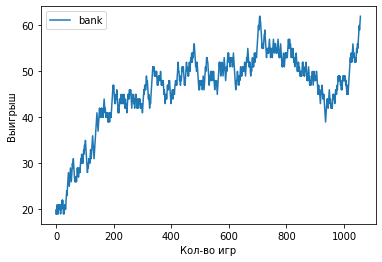

In [46]:
check_bank(models[33], tests[33][0], tests[33][1], True)

### Тестирование XGBRegressor

In [ ]:
res = xgb_estimate(40)

In [60]:
print("Средняя ошибка:", res[0])
print(f"Банк опустел в {res[1]} случаев")
print("Средний выигрыш:", res[2])

Средняя ошибка: 4.20116
Банк опустел в 0 случаев
Средний выигрыш: 53


In [ ]:
models = [pickle.load(open(f'model_xgb{i}.sav', 'rb')) for i in range(1,41)]
objlist = kFold(40)
tests = [[X_train.loc[i[1]],Y_train.loc[i[1]]] for i in objlist]

минимум = 17
максимум = 71
итого за 1000 игр = 69


['Вы не проиграли банк', 69]

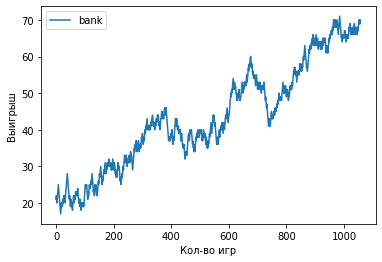

In [57]:
check_bank(models[29], tests[29][0], tests[29][1], True)